### Importing Libraries

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
os.environ["OMP_NUM_THREADS"] = '1'


from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from pandas.plotting import table
import dataframe_image as dfi

from pathlib import Path
import pickle

from clusteval import clusteval


### Selecting Path

In [2]:
def load_data(dataset, classifier):
    # Load dataset and change working directory
    path = Path(f'E:/Eighth Semester/EEE Capstone/8th Semester/{dataset}/{classifier}')
    os.chdir(path)

    df_encoded = pd.read_csv('df_encoded.csv')
    return df_encoded

def creating_cluster_data(df_encoded, classifier):
    
    # Run evaluation and save results
    with open(f'{classifier}_selected_features.pkl', 'rb') as f:
        corr_features, chi_sq_features, seq_fea_sel_features, rfe_cv_features = pickle.load(f)
    
    X = df_encoded[df_encoded['churn'] == 1].copy()
    # Select the relevant features for clustering
    X = X[seq_fea_sel_features]
    
    return X

def cluster_eval(X):
        # Initialize
    cl = clusteval(cluster='dbscan', 
                   evaluate='silhouette',
                max_clust=10
                )
    # find optimal number of clusters
    results = cl.fit(X)
    # Make plot
    cl.plot()
    # Show scatterplot with silhouette scores
    cl.scatter()


def plot_silhouette_scores(cluster_range, silhouette_scores, model_name):
    plt.figure(figsize=(12, 8))
    plt.plot(cluster_range, silhouette_scores, 'o-', linewidth=2)
    plt.xlabel('Number of Clusters', fontsize=16)
    plt.ylabel('Silhouette Score', fontsize=16)
    plt.grid(True)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.savefig(f"{model_name.__class__.__name__}_silhouette_scores.png", format='png', dpi=300, bbox_inches='tight')
    plt.savefig(f"{model_name.__class__.__name__}_silhouette_scores.pdf", format='pdf', bbox_inches='tight')
    plt.savefig(f"{model_name.__class__.__name__}_silhouette_scores.eps", format='eps', bbox_inches='tight')
    
    plt.show()


def plot_silhouette_analysis(model_instance, X, n_clusters):
    cluster_labels = model_instance.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    fig.suptitle(f"Silhouette analysis for {model_instance.__class__.__name__} (n_clusters={n_clusters})", fontsize=14, fontweight='bold')

    ax.set_xlim([-0.1, 1])
    ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = plt.cm.get_cmap('Spectral')(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
    ax.set_title("Silhouette plot")
    ax.set_xlabel("Silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    plt.show()

def find_optimal_clusters(model, X, cluster_range, plot_analysis=False):
    silhouette_scores = []
    for n_clusters in cluster_range:
        if isinstance(model, GaussianMixture):
            model_instance = model.set_params(n_components=n_clusters)
        elif isinstance(model, KMeans):
            model_instance = model.set_params(n_clusters=n_clusters)
        elif isinstance(model, DBSCAN):
            model_instance = model.set_params(eps=n_clusters)
        else:
            raise ValueError("Invalid model type")
        
        cluster_labels = model_instance.fit_predict(X)
        if len(np.unique(cluster_labels)) > 1:
            silhouette_avg = silhouette_score(X, cluster_labels)
            silhouette_scores.append(silhouette_avg)
            if plot_analysis:
                plot_silhouette_analysis(model_instance, X, n_clusters)
        else:
            silhouette_scores.append(-1)
    
    return silhouette_scores


def main():

    dataset = input("Enter dataset name: ")
    classifier = input("Enter classifier name: ")
    print("Dataset: ", dataset)
    print("Classifier: ", classifier)

    df_encoded = load_data(dataset, classifier)
    X = creating_cluster_data(df_encoded, classifier)

    # Normalize data
    scaler = StandardScaler()
    X_normalized = scaler.fit_transform(X)

    #clusteval(X_normalized)

    # Find optimal clusters for KMeans
    cluster_range = range(2, 11)
    model = KMeans(random_state=42, n_init=10)
    silhouette_scores = find_optimal_clusters(model, X_normalized, cluster_range, plot_analysis=False)
    plot_silhouette_scores(cluster_range, silhouette_scores, model)

    # Find optimal clusters for GaussianMixture
    model = GaussianMixture(random_state=42)
    silhouette_scores = find_optimal_clusters(model, X_normalized, cluster_range, plot_analysis=False)
    plot_silhouette_scores(cluster_range, silhouette_scores, model)

    # Find optimal eps value for DBSCAN
    eps_values = np.arange(0.1, 5.1, 0.1)
    model = DBSCAN(min_samples=5)
    silhouette_scores = find_optimal_clusters(model, X_normalized, eps_values, plot_analysis=False)
    plot_silhouette_scores(eps_values, silhouette_scores, model)

Dataset:  IBM Watson
Classifier:  BRF


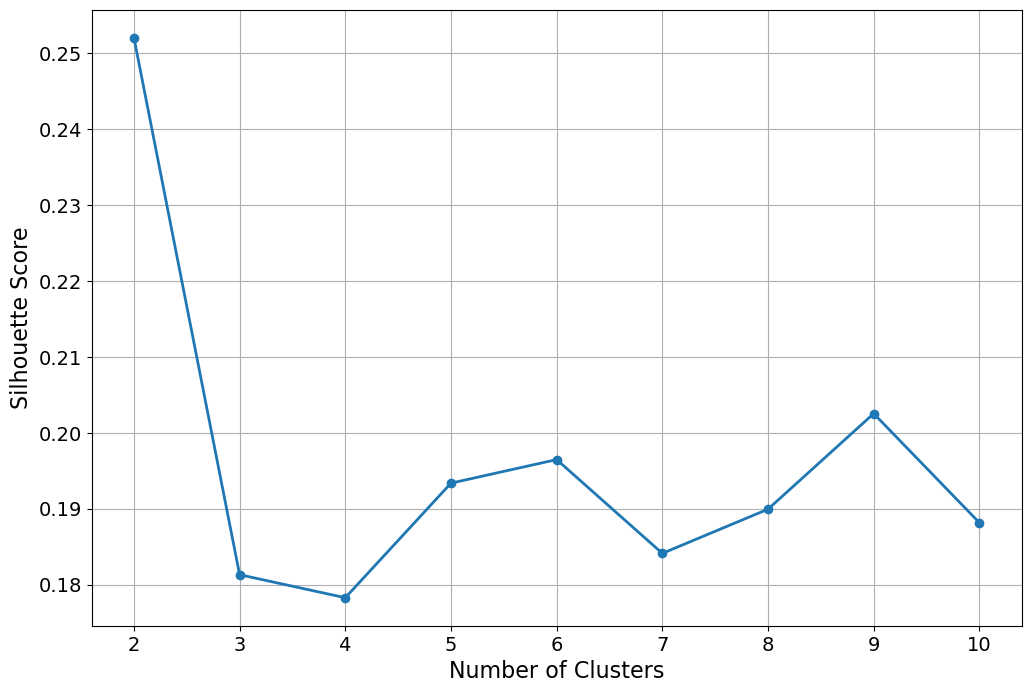

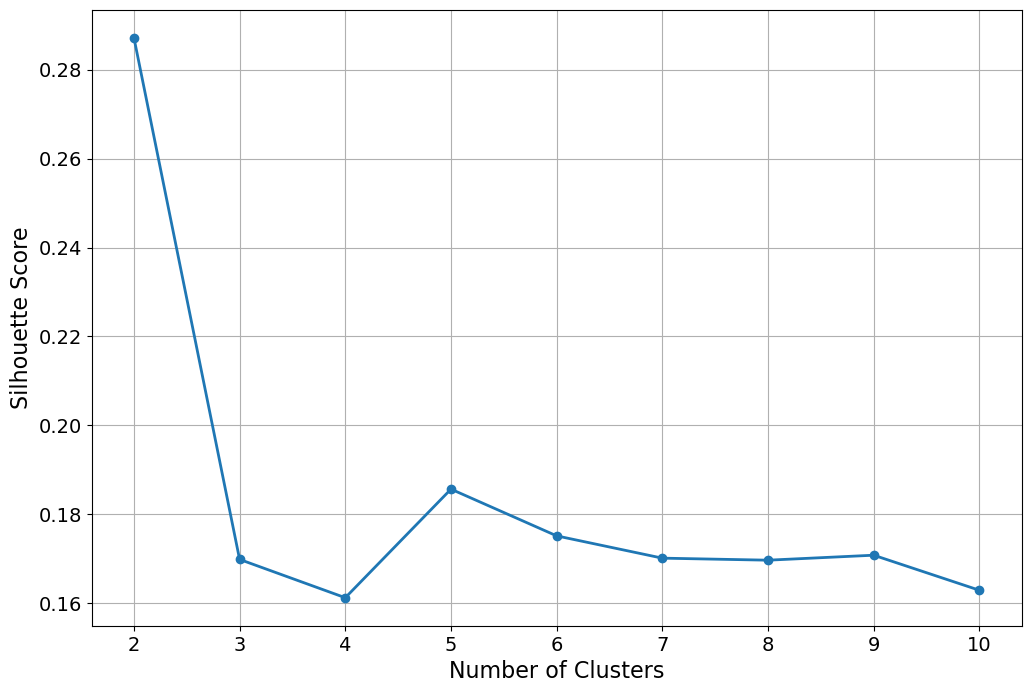

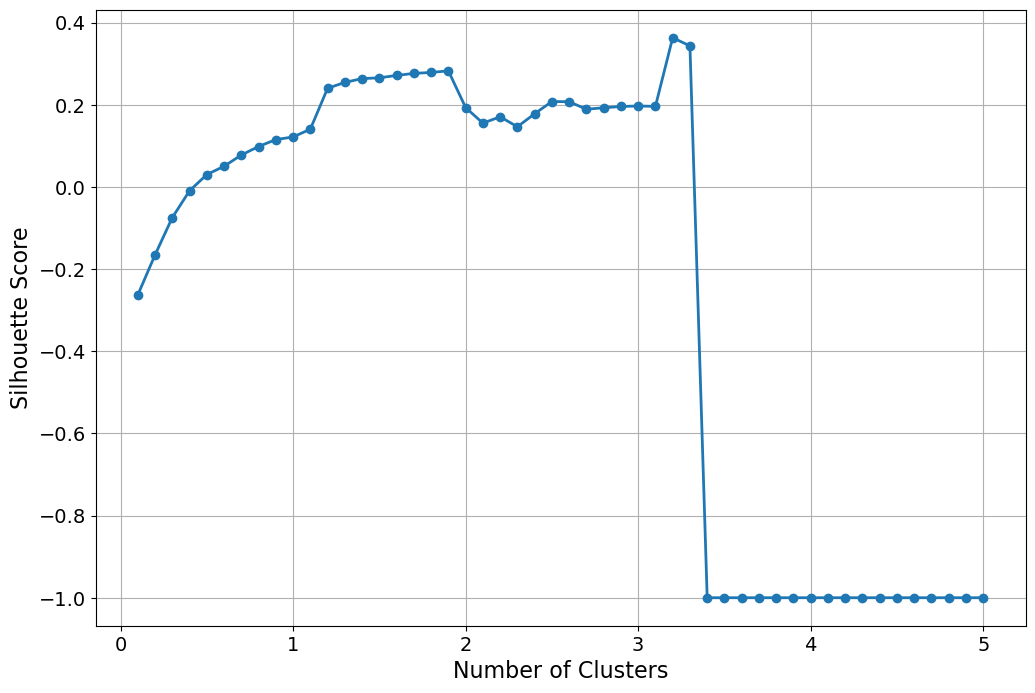

In [4]:
if __name__ == "__main__":
    main()

In [16]:
dataset = input("Enter dataset name: ")
classifier = input("Enter classifier name: ")
print("Dataset: ", dataset)
print("Classifier: ", classifier)

df_encoded = load_data(dataset, classifier)
X = creating_cluster_data(df_encoded, classifier)

# Normalize data
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

Dataset:  Orange
Classifier:  XGB


[clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|██████████| 23/23 [00:00<00:00, 180.62it/s]
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [4].
[clusteval] >INFO> Fin.


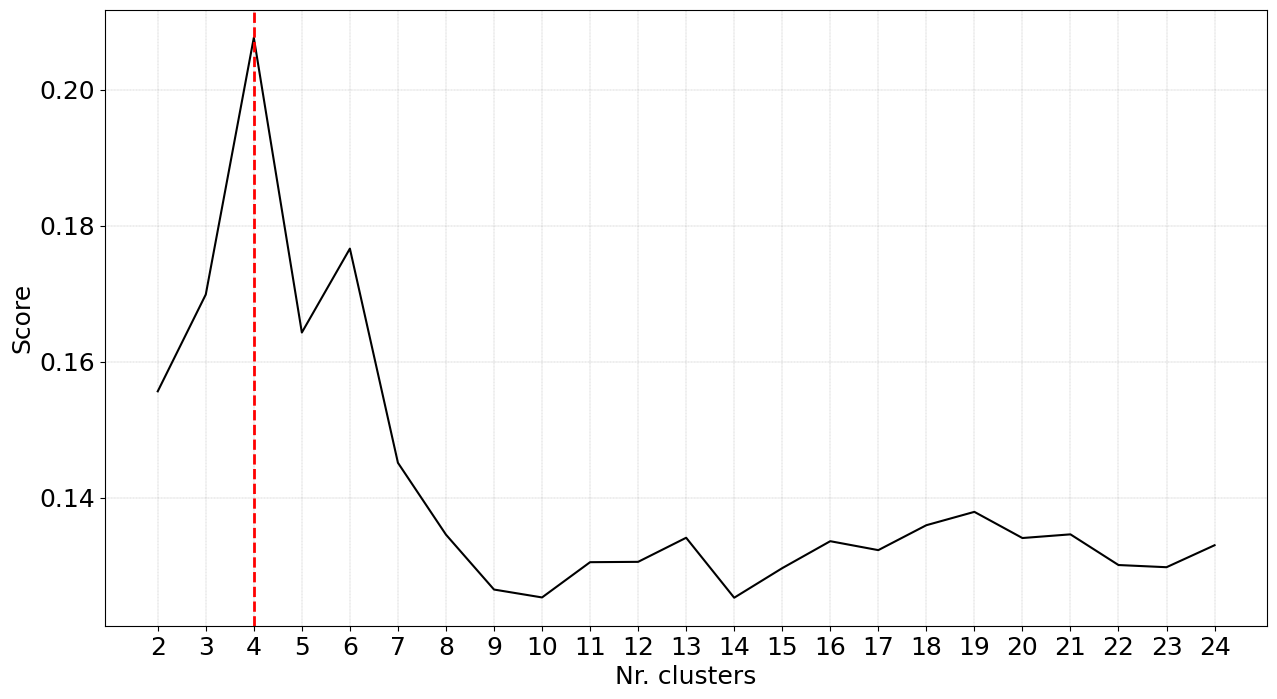

[clusteval] >INFO> Retrieving input data set.
[clusteval] >INFO> Coordinates (x, y) are set based on the first two features.
[clusteval] >INFO> Estimated number of n_clusters: 4, average silhouette_score=0.198


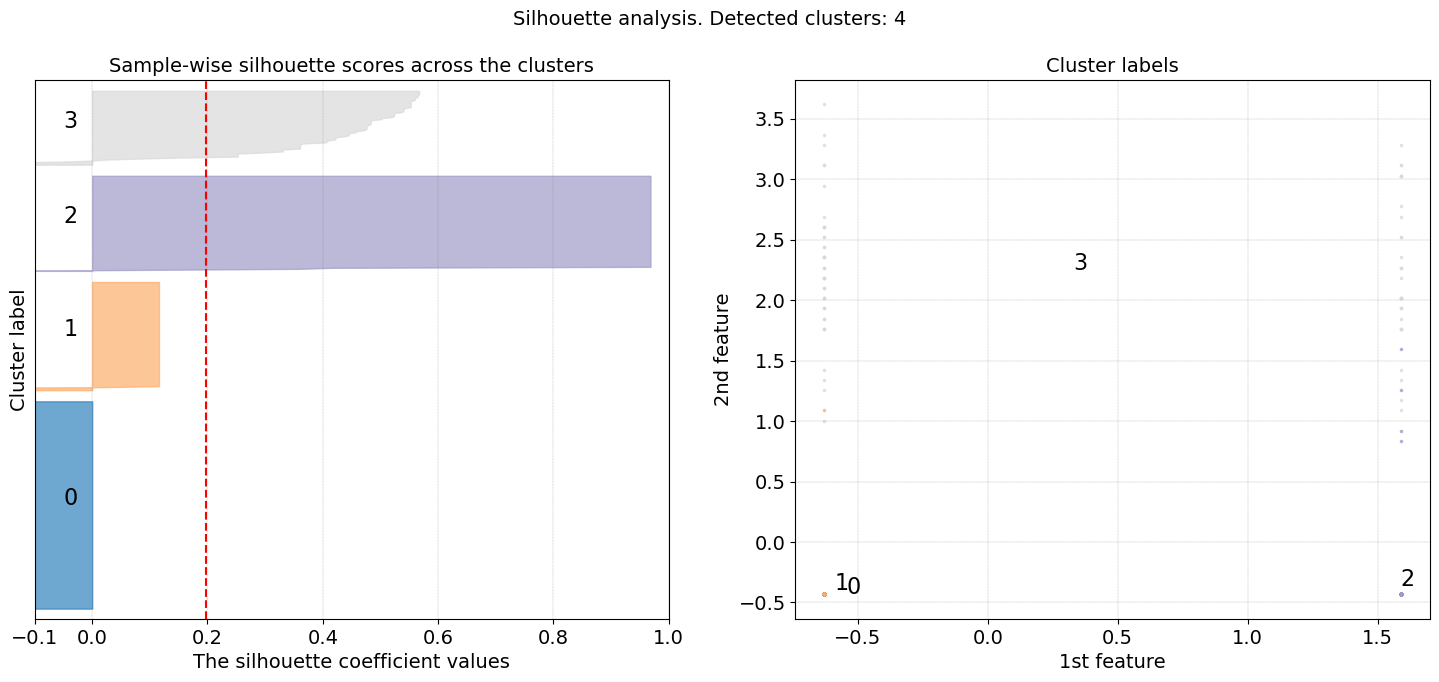

[clusteval] >INFO> Retrieving input data set.
[clusteval] >INFO> Coordinates (x, y) are set based on the first two features.
[clusteval] >INFO> Retrieving input data set.
[clusteval] >INFO> Plotting the dendrogram with optimized settings: metric=euclidean, linkage=ward, max_d=22.008. Be patient now..
[clusteval] >INFO> Compute cluster labels.


{'icoord': [[25.0, 25.0, 35.0, 35.0],
  [15.0, 15.0, 30.0, 30.0],
  [5.0, 5.0, 22.5, 22.5],
  [55.0, 55.0, 65.0, 65.0],
  [45.0, 45.0, 60.0, 60.0],
  [115.0, 115.0, 125.0, 125.0],
  [105.0, 105.0, 120.0, 120.0],
  [95.0, 95.0, 112.5, 112.5],
  [85.0, 85.0, 103.75, 103.75],
  [75.0, 75.0, 94.375, 94.375],
  [52.5, 52.5, 84.6875, 84.6875],
  [13.75, 13.75, 68.59375, 68.59375],
  [135.0, 135.0, 145.0, 145.0],
  [165.0, 165.0, 175.0, 175.0],
  [155.0, 155.0, 170.0, 170.0],
  [140.0, 140.0, 162.5, 162.5],
  [195.0, 195.0, 205.0, 205.0],
  [185.0, 185.0, 200.0, 200.0],
  [225.0, 225.0, 235.0, 235.0],
  [215.0, 215.0, 230.0, 230.0],
  [245.0, 245.0, 255.0, 255.0],
  [265.0, 265.0, 275.0, 275.0],
  [250.0, 250.0, 270.0, 270.0],
  [222.5, 222.5, 260.0, 260.0],
  [192.5, 192.5, 241.25, 241.25],
  [295.0, 295.0, 305.0, 305.0],
  [285.0, 285.0, 300.0, 300.0],
  [315.0, 315.0, 325.0, 325.0],
  [345.0, 345.0, 355.0, 355.0],
  [335.0, 335.0, 350.0, 350.0],
  [320.0, 320.0, 342.5, 342.5],
  [375.0, 37

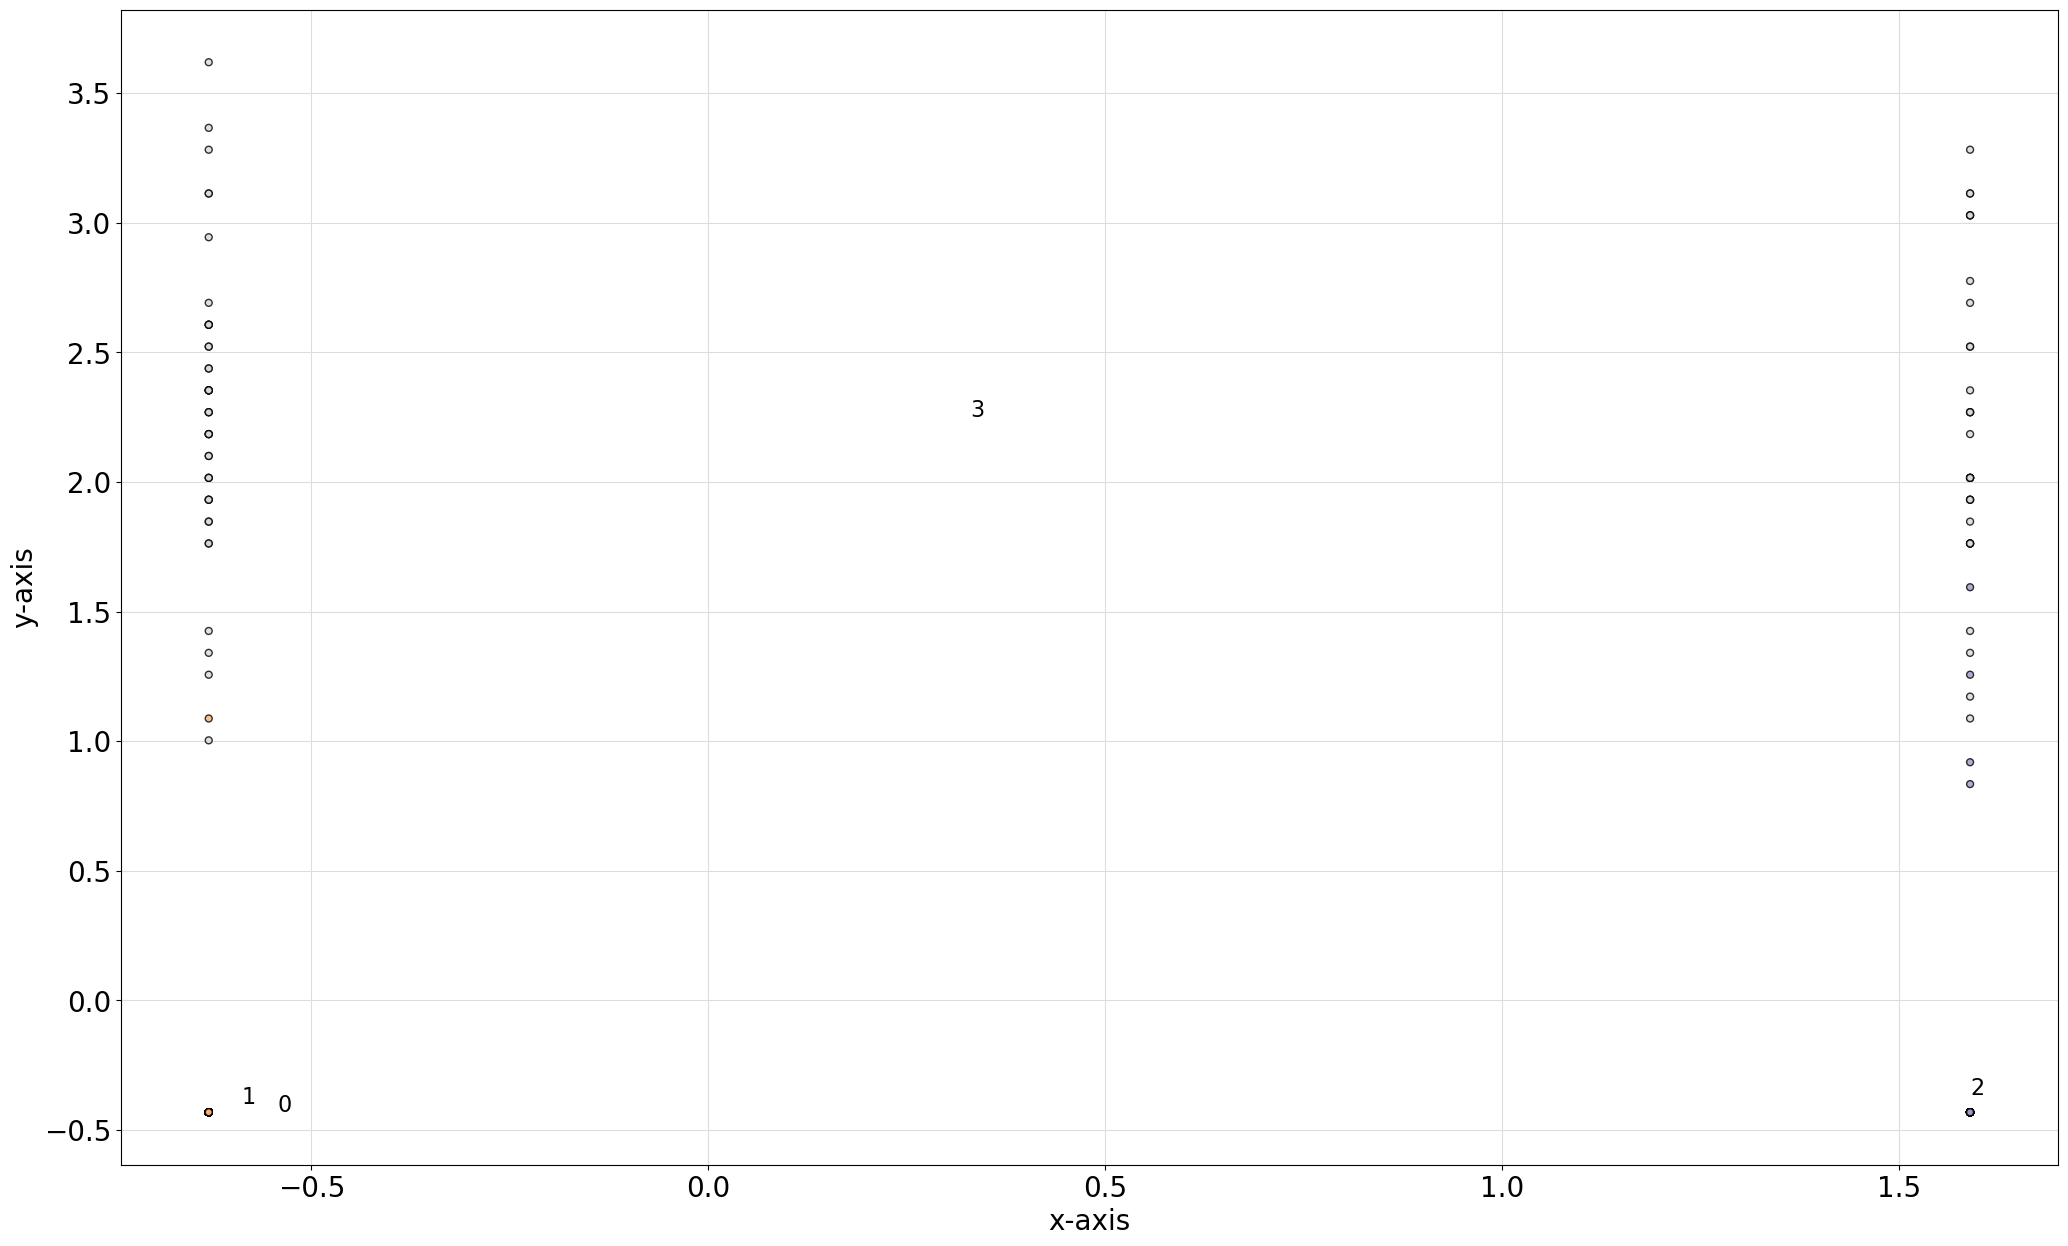

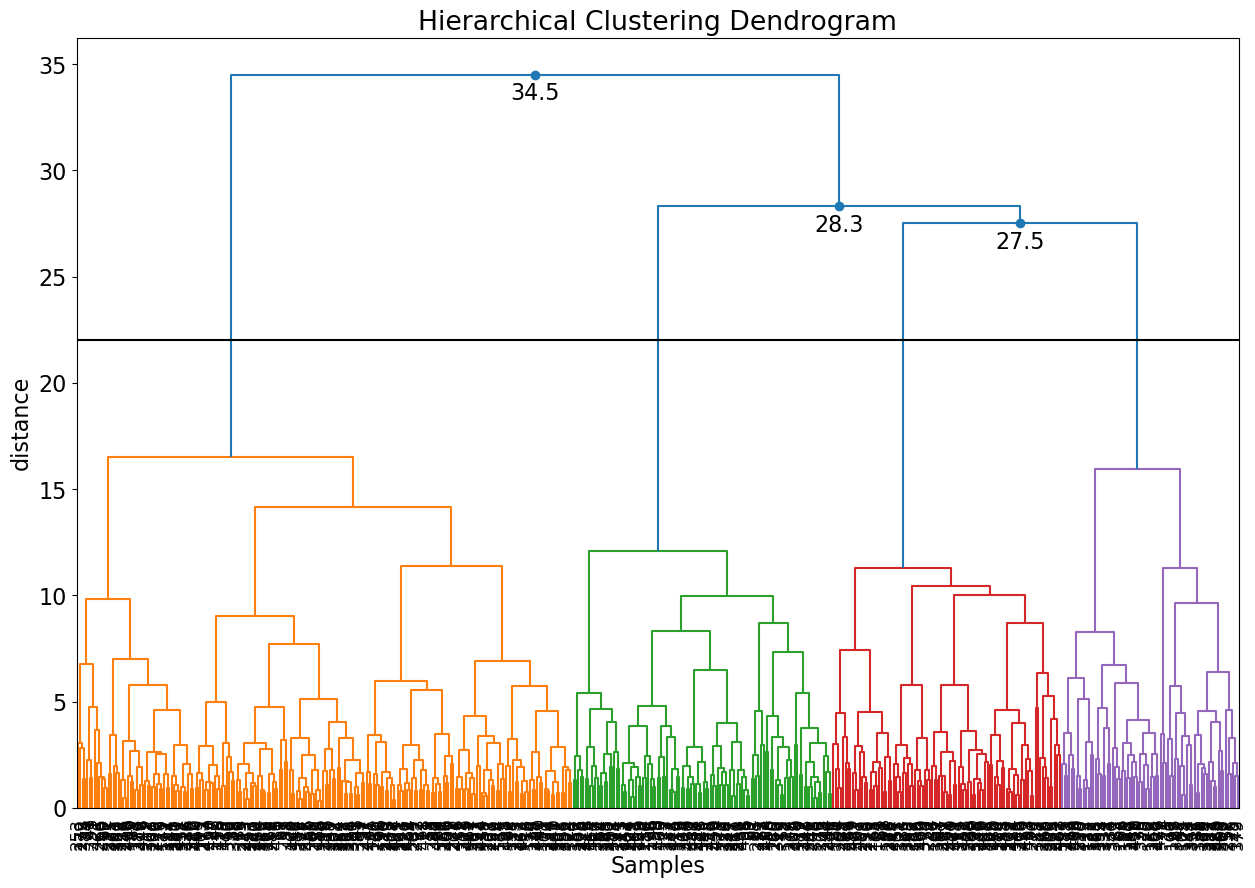

In [23]:
# Initialize
ce = clusteval(evaluate='silhouette')

# Fit
ce.fit(X_normalized)

# Plot
ce.plot()
ce.plot_silhouette()
ce.scatter()
ce.dendrogram()


In [20]:
if __name__ == "__main__":
    main()

Dataset:  Orange
Classifier:  XGB


e:\Anaconda\envs\tensorflow\lib\site-packages\numpy\lib\arraysetops.py:612: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


ValueError: cluster has incorrect input argument [[[-0.62924857 -0.43180325 -1.12894565 ...  0.71676965  0.72047371
   0.95615693]
 [-0.62924857 -0.43180325  1.82783451 ... -1.89943958  1.89743697
   0.95615693]
 [-0.62924857 -0.43180325 -2.09664554 ... -1.79192413  0.72047371
   1.49630173]
 ...
 [ 1.58919711 -0.43180325 -0.97080579 ... -0.35838483 -0.06416846
   0.95615693]
 [-0.62924857 -0.43180325  1.65663723 ...  0.28670786 -0.84881063
   0.95615693]
 [-0.62924857 -0.43180325 -1.28418387 ...  1.039316   -0.45648955
   1.49630173]]].

### Loading Dataset

## Clustering

### Kmeans

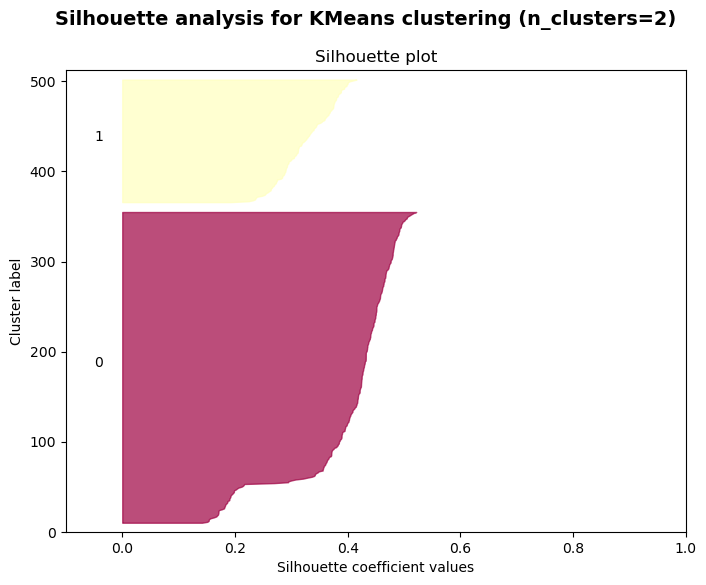

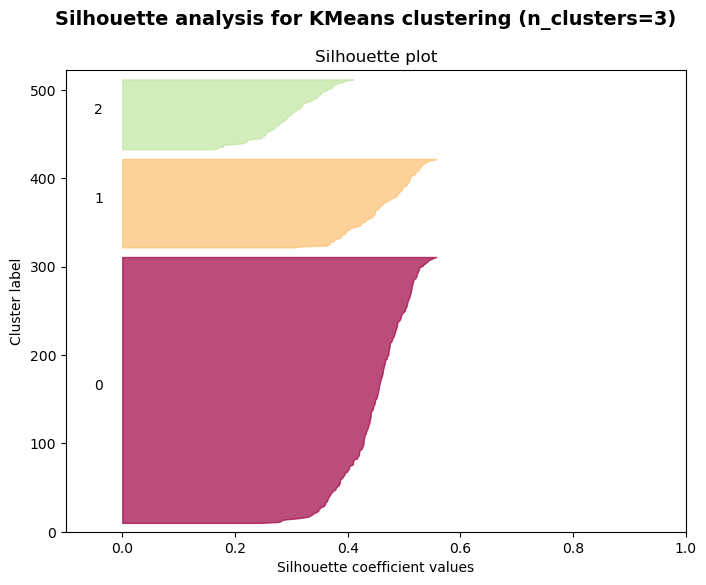

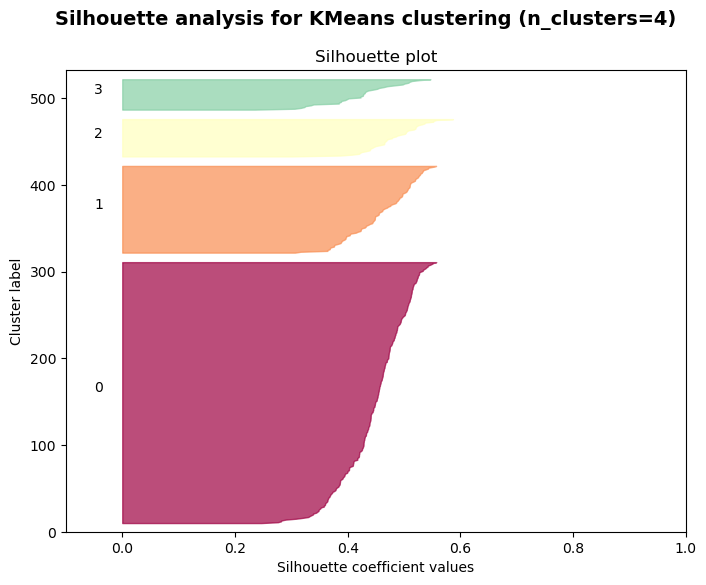

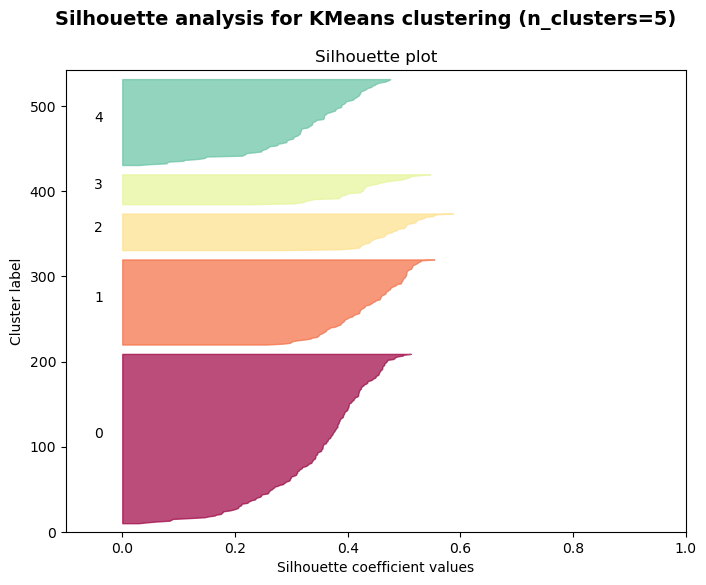

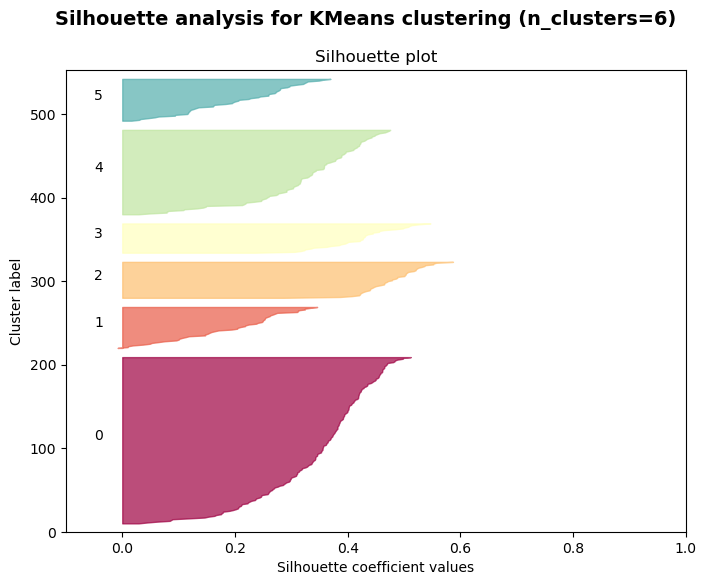

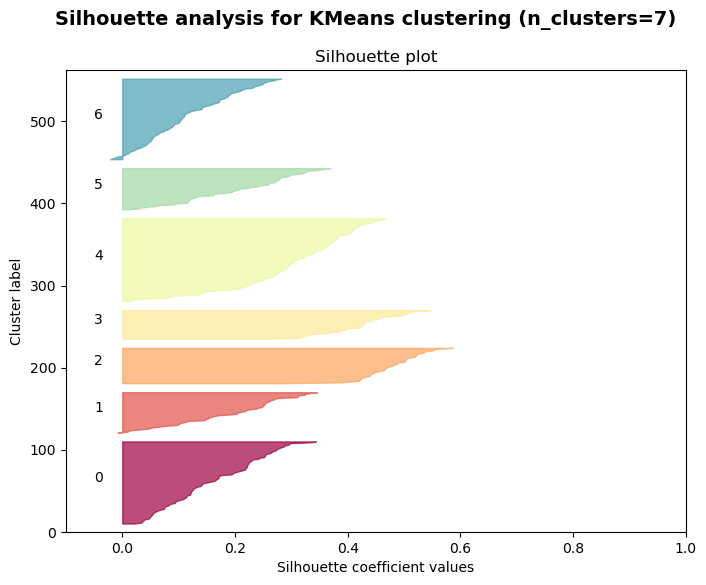

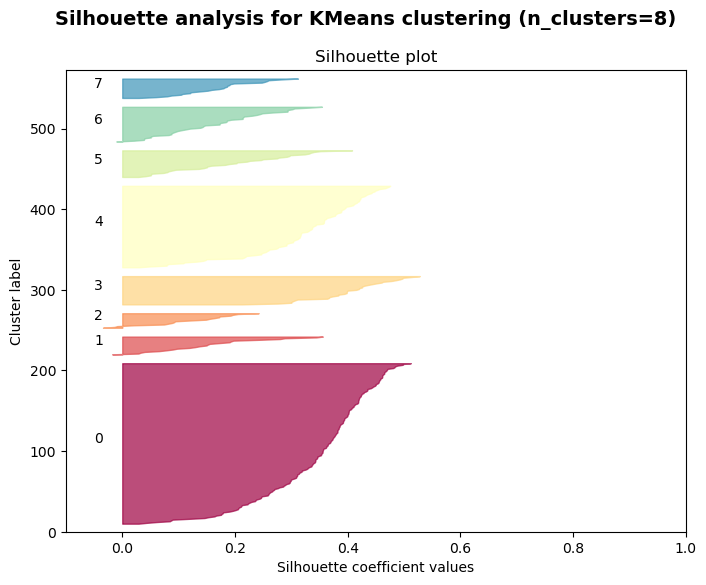

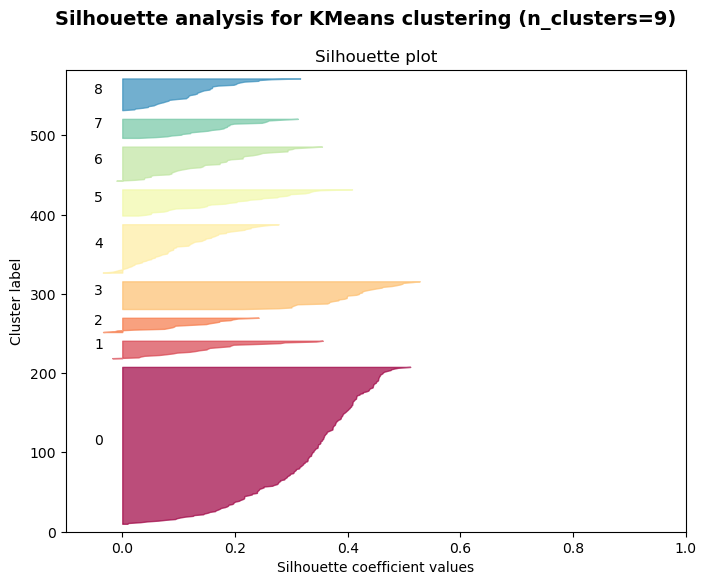

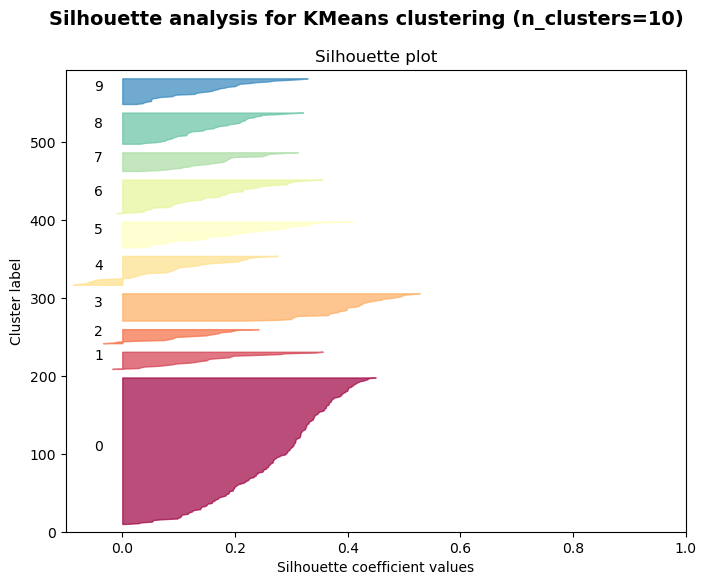

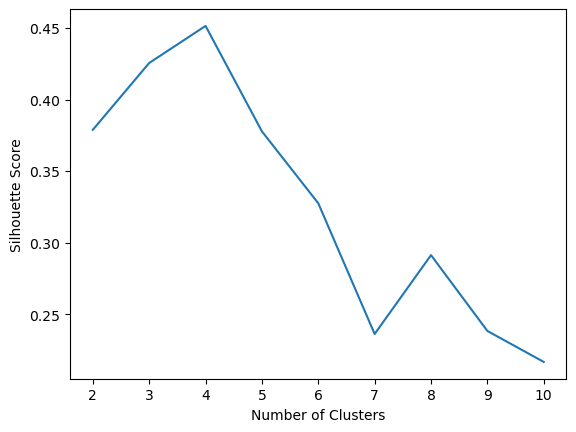

In [13]:

# Determine the optimal number of clusters using silhouette method
silhouette_scores = []
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
    cluster_labels = kmeans.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    
    # Create the silhouette plot
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    fig.suptitle(f"Silhouette analysis for KMeans clustering (n_clusters={n_clusters})", fontsize=14, fontweight='bold')
    
    # Plot the silhouette scores
    ax.set_xlim([-0.1, 1])
    ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = plt.cm.get_cmap('Spectral')(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
    ax.set_title("Silhouette plot")
    ax.set_xlabel("Silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    plt.show()

# Plot the silhouette scores
plt.plot(range(2, 11), silhouette_scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()


### Gaussian Mixture

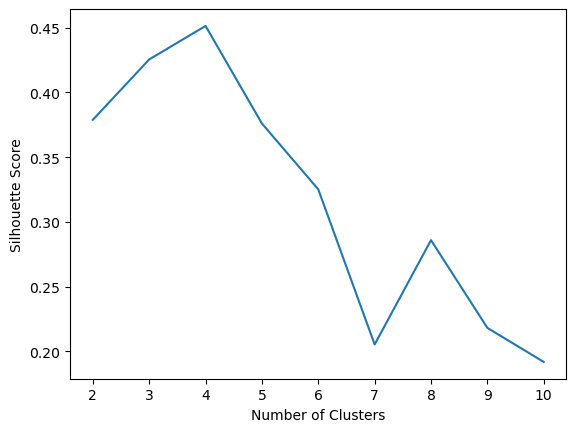

In [14]:
# Select the relevant features for clustering
X = df_churn[seq_fea_sel_features]

# Determine the optimal number of clusters using silhouette method
silhouette_scores = []
for n_clusters in range(2, 11):
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    cluster_labels = gmm.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the silhouette scores
plt.plot(range(2, 11), silhouette_scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()


### DBSCAN

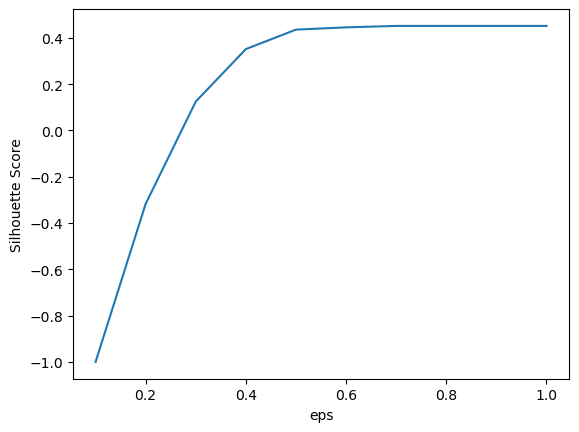

In [15]:
# Select the relevant features for clustering
X = df_churn[seq_fea_sel_features]

# Determine the optimal value for eps using silhouette method
silhouette_scores = []
eps_values = np.arange(0.1, 1.1, 0.1)
for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=5)
    cluster_labels = dbscan.fit_predict(X)
    if len(np.unique(cluster_labels)) > 1:
        silhouette_avg = silhouette_score(X, cluster_labels)
        silhouette_scores.append(silhouette_avg)
    else:
        silhouette_scores.append(-1)

# Plot the silhouette scores
plt.plot(eps_values, silhouette_scores)
plt.xlabel('eps')
plt.ylabel('Silhouette Score')
plt.show()
